<a href="https://colab.research.google.com/github/mukulre/Projects/blob/main/images_of_pneumonia_and_normal_att_mech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow optuna opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.2 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import tensorflow as tf
import optuna
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ========= CBAM Layer =========
class CBAMLayer(tf.keras.layers.Layer):
    def __init__(self, ratio=8):
        super(CBAMLayer, self).__init__()
        self.ratio = ratio

    def build(self, input_shape):
        channel = input_shape[-1]
        self.shared_dense_one = Dense(channel // self.ratio, activation='relu')
        self.shared_dense_two = Dense(channel)
        self.conv_spatial = Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        # Channel Attention
        avg_pool = GlobalAveragePooling2D()(inputs)
        max_pool = GlobalMaxPooling2D()(inputs)

        avg_out = self.shared_dense_two(self.shared_dense_one(avg_pool))
        max_out = self.shared_dense_two(self.shared_dense_one(max_pool))
        channel_attention = Activation('sigmoid')(avg_out + max_out)
        channel_attention = Reshape((1, 1, -1))(channel_attention)
        x = Multiply()([inputs, channel_attention])

        # Spatial Attention
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])
        spatial_attention = self.conv_spatial(concat)
        x = Multiply()([x, spatial_attention])
        return x

# ========= Model Builder =========
def build_model(dropout_rate, learning_rate):
    inputs = Input(shape=(300, 300, 3))
    base_model = EfficientNetB3(include_top=False, input_tensor=inputs, weights='imagenet')
    x = CBAMLayer()(base_model.output)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ========= Data Loading =========
img_size = (300, 300)
batch_size = 16
data_dir = '/content/drive/MyDrive/Pneumonia Detection/chest_xray/'

train_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2,
                               width_shift_range=0.1, height_shift_range=0.1,
                               shear_range=0.2, horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(os.path.join(data_dir, 'train'),
                                           target_size=img_size, batch_size=batch_size,
                                           class_mode='binary')
val_data = val_gen.flow_from_directory(os.path.join(data_dir, 'val'),
                                       target_size=img_size, batch_size=batch_size,
                                       class_mode='binary')

# ========= Optuna Optimization =========
def objective(trial):
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.6)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    model = build_model(dropout_rate, learning_rate)
    model.fit(train_data, validation_data=val_data, epochs=2, verbose=0)
    _, val_acc = model.evaluate(val_data, verbose=0)
    return val_acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# ========= Final Training with Best Params =========
best_params = study.best_params
final_model = build_model(best_params['dropout_rate'], best_params['learning_rate'])
final_model.fit(train_data, validation_data=val_data, epochs=5)
final_model.save('/content/drive/MyDrive/Pneumonia Detection/models/cbam_effnetb3_optuna.h5')

# ========= Grad-CAM =========
def make_gradcam_heatmap(img_array, model, layer_name):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8  # avoid divide by zero
    return heatmap

def show_gradcam(image_path, model, true_label):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    input_img = np.expand_dims(img_array / 255.0, axis=0)
    prediction = model.predict(input_img)[0][0]
    pred_label = 'Pneumonia' if prediction > 0.5 else 'Normal'

    heatmap = make_gradcam_heatmap(input_img, model, 'top_conv')
    heatmap = cv2.resize(heatmap, img_size[::-1])
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_array.astype('uint8'), 0.6, heatmap, 0.4, 0)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img_array.astype('uint8'))
    axs[0].set_title(f'Original: {true_label}')
    axs[1].imshow(heatmap)
    axs[1].set_title('Grad-CAM Heatmap')
    axs[2].imshow(superimposed)
    axs[2].set_title(f'Prediction: {pred_label}')
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# ========= Grad-CAM Example =========
example_img = os.path.join(data_dir, 'test', 'PNEUMONIA', os.listdir(os.path.join(data_dir, 'test', 'PNEUMONIA'))[0])
show_gradcam(example_img, final_model, true_label='Pneumonia')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


[I 2025-05-22 16:28:39,607] A new study created in memory with name: no-name-8be52991-a0ad-49cd-8f13-a7959b912ed1
[W 2025-05-22 16:29:14,433] Trial 0 failed with parameters: {'dropout_rate': 0.5935855366824346, 'learning_rate': 0.00045385393854597064} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/func_graph.py", line 1059, in func_graph_from_py_func
    func_outputs = python_func(*func_args, **func_kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 599, in wrapped_fn
    out = weak_wrapped_fn().__wrapped__(*args, **kwds)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/autograph_util.py", line 41, in autograph_handler
    return api.con

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


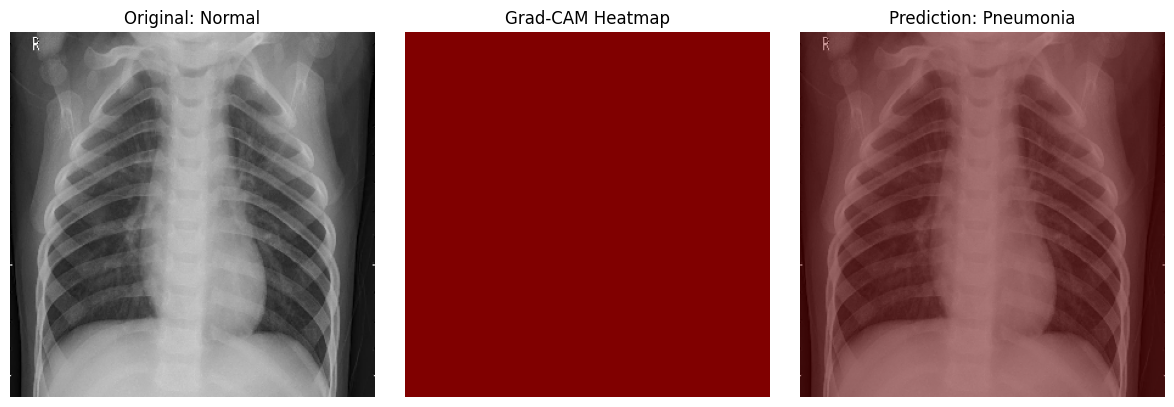

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


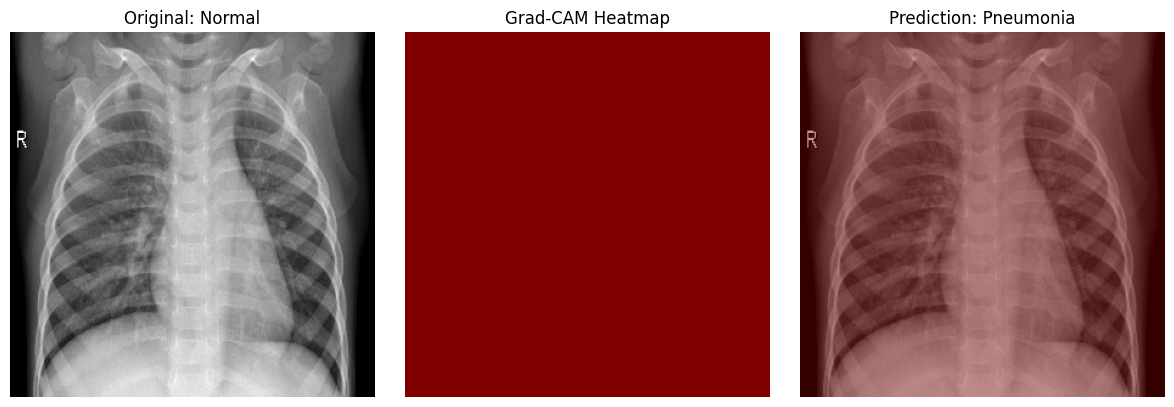

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


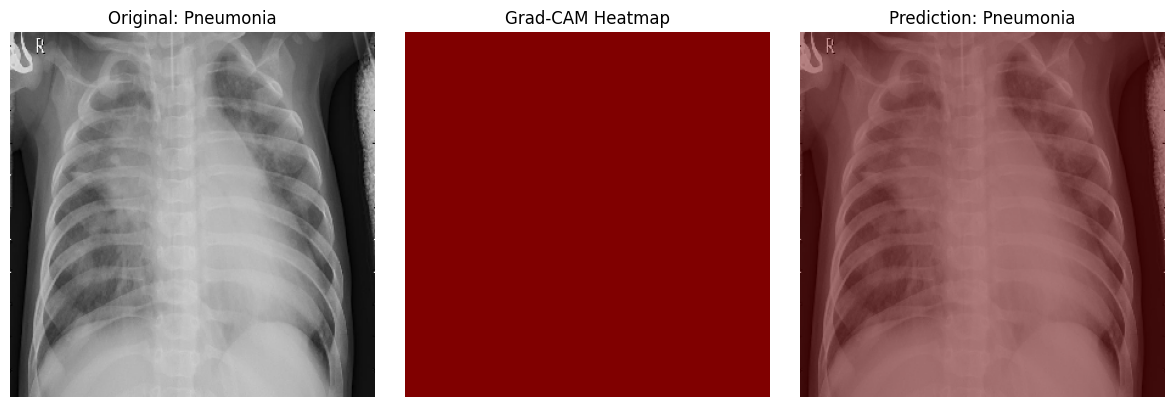

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


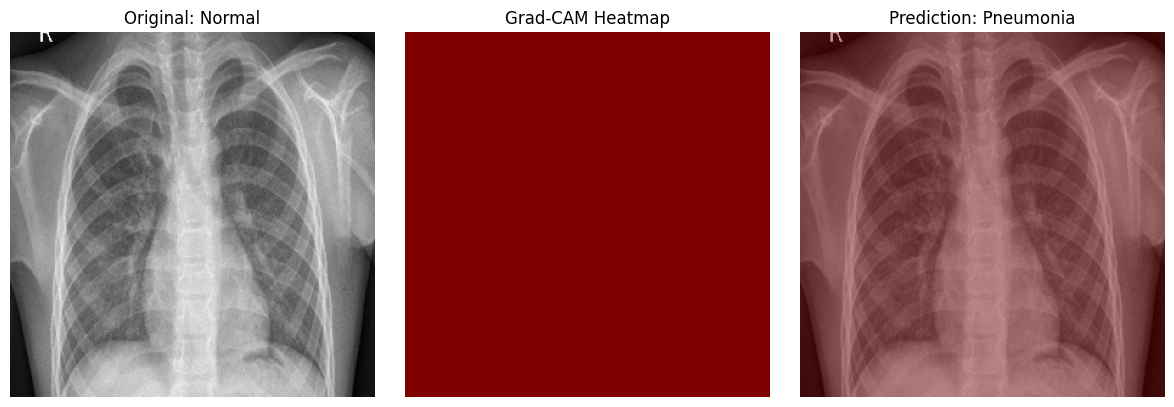

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


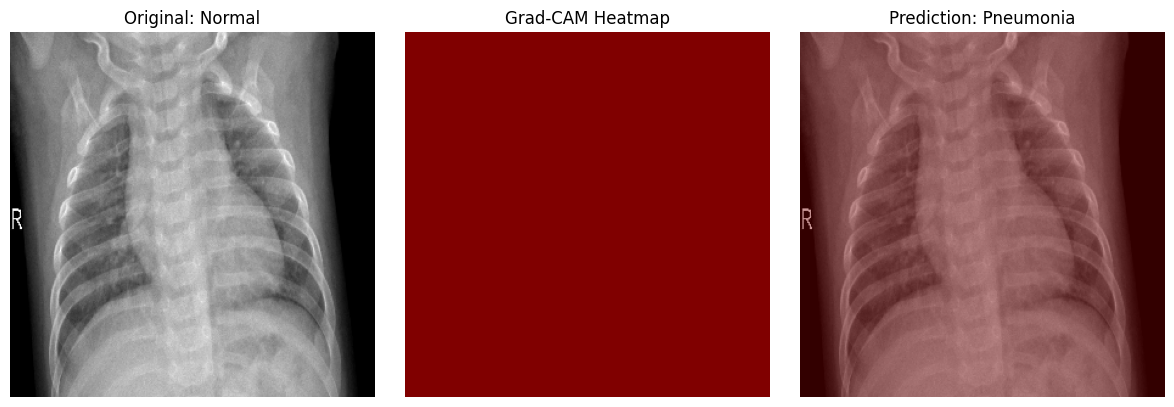

In [ ]:
import random

# Folder containing test images
test_dirs = [os.path.join(data_dir, 'test', cls) for cls in ['PNEUMONIA', 'NORMAL']]
test_images = []

# Collect test image paths
for folder in test_dirs:
    imgs = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    test_images.extend(imgs)

# Select 5 random test images
random_imgs = random.sample(test_images, 5)

# Plot Grad-CAMs
for img_path in random_imgs:
    true_label = "Pneumonia" if "PNEUMONIA" in img_path else "Normal"
    show_gradcam(img_path, final_model, true_label=true_label)